<a href="https://colab.research.google.com/github/AnastasiaZAYU/Modeling_with_SIR_model/blob/main/Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Набір даних та інструменти

In [1]:
from datetime import datetime
time_format = "%d%b%Y %H:%M"
datetime.now().strftime(time_format)
!pip install --upgrade "git+https://github.com/lisphilar/covid19-sir.git#egg=covsirphy"
import covsirphy as cs
!pip install openpyxl
from collections import defaultdict
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import functools
from IPython.display import display, Markdown
import math
import os
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
import scipy as sci
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import sympy as sym
np.random.seed(123)
os.environ["PYTHONHASHSEED"] = "123"
plt.style.use("seaborn-ticks")
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.size"] = 11.0
plt.rcParams["figure.figsize"] = (9, 6)
pd.set_option("display.max_colwidth", 1000)
data_loader = cs.DataLoader(directory="kaggle/input")
jhu_data = data_loader.jhu()
covid_df = jhu_data.cleaned()
df = covid_df.pivot_table(
    index="Date", columns="Country", values="Confirmed", aggfunc="sum"
).fillna(method="ffill").fillna(0)
df = df.diff() / df.diff().shift(freq="D")
df = df.replace(np.inf, np.nan).fillna(1.0)
df = df.rolling(7).mean().dropna().loc[:covid_df["Date"].max(), :]
growth_value_df = df.round(2)
growth_value_df.tail()
df = growth_value_df.copy()
df = df.iloc[-7:, :].T
day_cols = df.columns.strftime("%d%b%Y")
df.columns = day_cols
last_date = day_cols[-1]
more_col, less_col = "GF > 1 [straight days]", "GF < 1 [straight days]"
df[more_col] = (growth_value_df > 1).iloc[::-1].cumprod().sum(axis=0)
df[less_col] = (growth_value_df < 1).iloc[::-1].cumprod().sum(axis=0)
df["Group"] = df[[more_col, less_col]].apply(
    lambda x: "Outbreaking" if x[0] >= 7 else "Stopping" if x[1] >= 7 else "Crossroad",
    axis=1
)
df = df.loc[:, ["Group", more_col, less_col, *day_cols]]
df = df.sort_values(["Group", more_col, less_col], ascending=False)
growth_df = df.copy()
growth_df.head()

Країни, у яких спостерігається спад захворюваності

In [2]:
df = growth_df.loc[growth_df["Group"] == "Stopping", :]
", ".join(df.index.tolist()) + "."

'Costa Rica, Botswana, Libya, Bosnia and Herzegovina, Ecuador, Bahamas, Belize, Guam, Anguilla, Iceland, Republic of the Congo, Grenada, Cyprus, Finland, Cayman Islands, Andorra, Haiti, Fiji, Saint Vincent and the Grenadines, Greenland, Cambodia, Democratic Republic of the Congo, Dominica, Ghana, Serbia, Syria, Gambia, Venezuela, Hungary, Nicaragua, Tajikistan, Yemen, Namibia, Brunei, Guinea-Bissau, Paraguay, Bonaire, Sint Eustatius and Saba, Nigeria, Russia, Tanzania, Gabon, Myanmar, Turks and Caicos Islands, Bolivia, Benin, Bermuda, Northern Mariana Islands, San Marino, Faroe Islands, Honduras, Niger, Somalia, Equatorial Guinea, Kazakhstan.'

Країни, у яких спостерігається спалах захворюваності

In [3]:
df = growth_df.loc[growth_df["Group"] == "Outbreaking", :]
", ".join(df.index.tolist()) + "."

'Spain, French Guiana, Slovenia, Guadeloupe, Réunion, Germany, United States, Croatia, Poland, Greece, Switzerland, Martinique, Guatemala, Czech Republic, Slovakia, Georgia, Latvia, Bulgaria, Mayotte, Portugal, France, Peru, Italy, South Africa, New Caledonia, North Macedonia, Trinidad and Tobago, Papua New Guinea, Vietnam, Comoros, Algeria, Morocco, Kenya, South Korea, Taiwan, Azerbaijan, Eritrea, Isle of Man, Laos, Uruguay, Lithuania, Malta, Aruba, Brazil, Mali, Tunisia, Armenia, Indonesia, Luxembourg, Puerto Rico, Mauritania, Cape Verde, Australia, Estonia, Japan, Rwanda.'

Обрано такі країни для дослідження: 
Кіпр (Cyprus) - затухання захворюваності,
Люксембург (Luxembourg) - спалах захворюваності

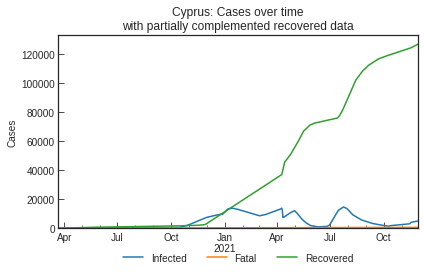

,Date,Infected,Fatal,Recovered
612,2021-11-24,5217,591,125654
613,2021-11-25,4951,591,125920
614,2021-11-26,5165,591,126195
615,2021-11-27,4911,591,126449
616,2021-11-28,4911,591,126449


In [4]:
cyp_scenario = cs.Scenario(country="Cyprus")
cyp_scenario.register(jhu_data)
cyp_scenario.records().tail()

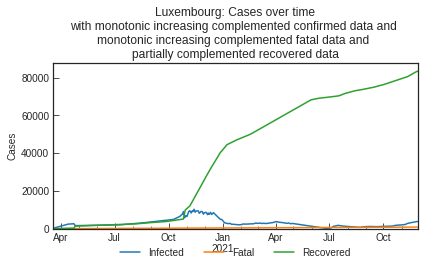

,Date,Infected,Fatal,Recovered
616,2021-11-24,3863,862,82627
617,2021-11-25,3935,864,82974
618,2021-11-26,4027,866,83215
619,2021-11-27,3849,866,83393
620,2021-11-28,3849,866,83393


In [5]:
lux_scenario = cs.Scenario(country="Luxembourg")
lux_scenario.register(jhu_data)
lux_scenario.records().tail()

In [6]:
_ = cyp_scenario.trend()
_ = lux_scenario.trend()

In [7]:
cyp_scenario.estimate(cs.SIRF, timeout=120)

Знаходження параметрів SIR-F моделі для Кіпру

In [8]:
cyp_scenario.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],RMSLE,Trials,Runtime
0th,Past,22Mar2020,12Apr2020,1189265,SIR-F,7.02,0.033028,0.000399,0.109628,0.014707,1440,0.033,2505,9,67,0.286729,285.0,0 min 9 sec
1st,Past,13Apr2020,01Aug2020,1189265,SIR-F,0.52,0.018728,0.000000,0.016208,0.030714,1440,-,-,-,-,0.238403,290.0,0 min 8 sec
2nd,Past,02Aug2020,30Sep2020,1189265,SIR-F,1.10,0.007964,0.000000,0.028800,0.026004,1440,-,-,-,-,0.205356,265.0,0 min 7 sec
3rd,Past,01Oct2020,19Oct2020,1189265,SIR-F,1.96,0.000242,0.000705,0.077744,0.039005,1440,0,1417,12,25,0.067827,296.0,0 min 9 sec
4th,Past,20Oct2020,27Oct2020,1189265,SIR-F,7.48,0.000776,0.000000,0.113869,0.015220,1440,-,-,-,-,0.026527,198.0,0 min 5 sec
5th,Past,28Oct2020,06Nov2020,1189265,SIR-F,21.44,0.000276,0.000047,0.067291,0.003091,1440,0,21466,14,323,0.013230,270.0,0 min 8 sec
6th,Past,07Nov2020,18Nov2020,1189265,SIR-F,27.73,0.004116,0.000160,0.038458,0.001221,1440,0.004,6241,26,819,0.035250,145.0,0 min 4 sec
7th,Past,19Nov2020,01Dec2020,1189265,SIR-F,6.60,0.000989,0.000062,0.041712,0.006255,1440,0.001,16057,23,159,0.063412,182.0,0 min 5 sec
8th,Past,02Dec2020,10Dec2020,1189265,SIR-F,1.23,0.000026,0.000335,0.042577,0.034418,1440,0,2983,23,29,0.008254,373.0,0 min 12 sec
9th,Past,11Dec2020,19Dec2020,1189265,SIR-F,1.49,0.000093,0.000259,0.044839,0.029820,1440,0,3854,22,33,0.013172,213.0,0 min 6 sec


In [9]:
lux_scenario.estimate(cs.SIRF, timeout=120)

Знаходження параметрів SIR-F моделі для Люксембургу

In [10]:
lux_scenario.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],RMSLE,Trials,Runtime
0th,Past,18Mar2020,26Mar2020,607950,SIR-F,44.30,0.000132,0.003291,0.269786,0.002798,1440,0,303,3,357,0.240899,363.0,0 min 12 sec
1st,Past,27Mar2020,06Apr2020,607950,SIR-F,6.29,0.010167,0.000749,0.073014,0.010748,1440,0.01,1335,13,93,0.249444,148.0,0 min 4 sec
2nd,Past,07Apr2020,27Apr2020,607950,SIR-F,1.23,0.015805,0.001013,0.010571,0.007450,1440,0.016,986,94,134,0.317171,321.0,0 min 10 sec
3rd,Past,28Apr2020,05Jul2020,607950,SIR-F,0.81,0.028953,0.000170,0.003985,0.004625,1440,0.029,5899,250,216,0.052645,205.0,0 min 6 sec
4th,Past,06Jul2020,14Jul2020,607950,SIR-F,5.36,0.000567,0.000106,0.026768,0.004888,1440,0.001,9393,37,204,0.006092,150.0,0 min 4 sec
5th,Past,15Jul2020,23Jul2020,607950,SIR-F,4.91,0.000097,0.000067,0.035433,0.007144,1440,0,14968,28,139,0.010184,267.0,0 min 8 sec
6th,Past,24Jul2020,03Aug2020,607950,SIR-F,2.11,0.000039,0.000160,0.025234,0.011797,1440,0,6252,39,84,0.011920,263.0,0 min 8 sec
7th,Past,04Aug2020,20Aug2020,607950,SIR-F,0.96,0.008893,0.000018,0.012503,0.012895,1440,0.009,55807,79,77,0.007176,315.0,0 min 10 sec
8th,Past,21Aug2020,08Sep2020,607950,SIR-F,2.12,0.000456,0.000000,0.009198,0.004336,1440,-,-,-,-,0.006645,508.0,0 min 16 sec
9th,Past,09Sep2020,20Sep2020,607950,SIR-F,2.83,0.000863,0.000000,0.017387,0.006138,1440,-,-,-,-,0.012597,46.0,0 min 1 sec


Зміна параметрів SIR-F моделі з плином часу 

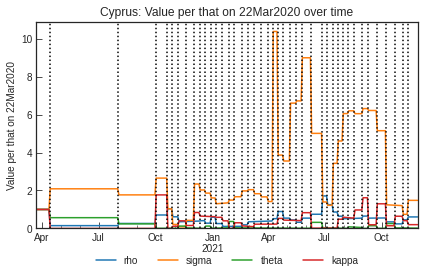

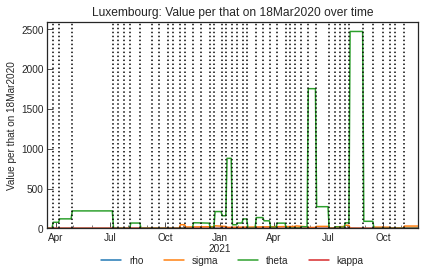

In [11]:
_ = cyp_scenario.history_rate()

_ = lux_scenario.history_rate()

Прогнозування рівня захворюваності на 7 днів для Кіпру

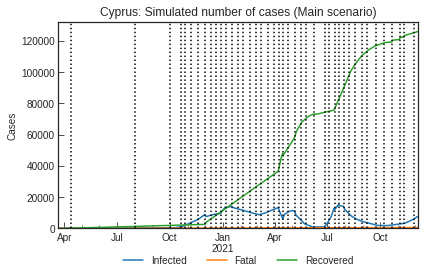

,Date,Infected,Fatal,Recovered
617,2021-11-29 00:00:00,6101,596,125076
618,2021-11-30 00:00:00,6332,596,125212
619,2021-12-01 00:00:00,6572,597,125352
620,2021-12-02 00:00:00,6821,598,125498
621,2021-12-03 00:00:00,7080,599,125649
622,2021-12-04 00:00:00,7347,599,125806
623,2021-12-05 00:00:00,7625,600,125969


In [12]:
cyp_scenario.clear()
cyp_scenario.add(days=7)
cyp_scenario.simulate().tail(7).style.background_gradient(axis=0)

Прогнозування рівня захворюваності на 30 днів для Кіпру

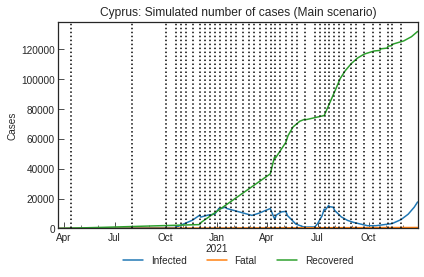

,Date,Infected,Fatal,Recovered
640,2021-12-22 00:00:00,14262,620,129894
641,2021-12-23 00:00:00,14792,622,130210
642,2021-12-24 00:00:00,15341,624,130538
643,2021-12-25 00:00:00,15909,625,130878
644,2021-12-26 00:00:00,16498,627,131231
645,2021-12-27 00:00:00,17108,629,131596
646,2021-12-28 00:00:00,17739,631,131975


In [13]:
cyp_scenario.clear()
cyp_scenario.add(days=30)
cyp_scenario.simulate().tail(7).style.background_gradient(axis=0)

Прогнозування рівня захворюваності на 300 днів для Кіпру

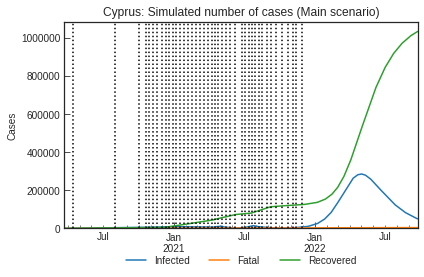

,Date,Infected,Fatal,Recovered
910,2022-09-18 00:00:00,55529,4410,1025642
911,2022-09-19 00:00:00,54645,4414,1026841
912,2022-09-20 00:00:00,53773,4419,1028021
913,2022-09-21 00:00:00,52915,4423,1029182
914,2022-09-22 00:00:00,52069,4428,1030324
915,2022-09-23 00:00:00,51236,4432,1031448
916,2022-09-24 00:00:00,50415,4436,1032554


In [14]:
cyp_scenario.clear()
cyp_scenario.add(days=300)
cyp_scenario.simulate().tail(7).style.background_gradient(axis=0)

Прогнозування рівня захворюваності на 7 днів для Люксембургу

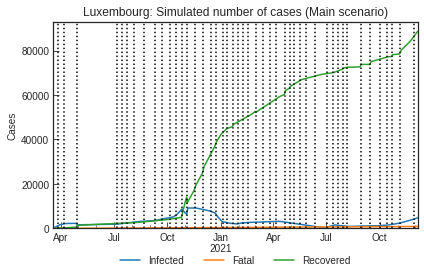

,Date,Infected,Fatal,Recovered
621,2021-11-29 00:00:00,4184,889,86337
622,2021-11-30 00:00:00,4276,891,86692
623,2021-12-01 00:00:00,4369,893,87054
624,2021-12-02 00:00:00,4464,896,87424
625,2021-12-03 00:00:00,4561,898,87802
626,2021-12-04 00:00:00,4659,900,88189
627,2021-12-05 00:00:00,4759,902,88583


In [15]:
lux_scenario.clear()
lux_scenario.add(days=7)
lux_scenario.simulate().tail(7).style.background_gradient(axis=0)

Прогнозування рівня захворюваності на 30 днів для Люксембургу

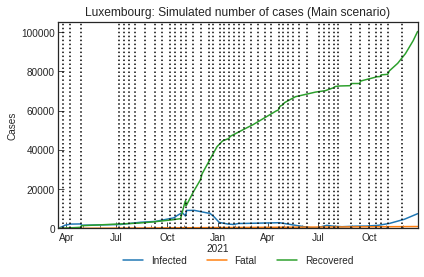

,Date,Infected,Fatal,Recovered
644,2021-12-22 00:00:00,6705,951,96696
645,2021-12-23 00:00:00,6833,954,97263
646,2021-12-24 00:00:00,6963,958,97842
647,2021-12-25 00:00:00,7095,961,98431
648,2021-12-26 00:00:00,7228,965,99031
649,2021-12-27 00:00:00,7362,968,99643
650,2021-12-28 00:00:00,7498,972,100265


In [16]:
lux_scenario.clear()
lux_scenario.add(days=30)
lux_scenario.simulate().tail(7).style.background_gradient(axis=0)

Прогнозування рівня захворюваності на 300 днів для Люксембургу

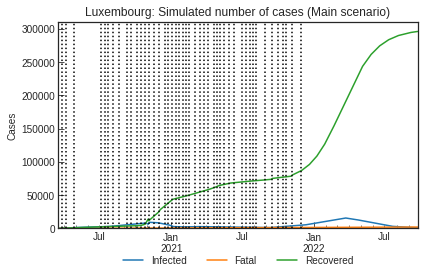

,Date,Infected,Fatal,Recovered
914,2022-09-18 00:00:00,972,2109,295335
915,2022-09-19 00:00:00,952,2110,295416
916,2022-09-20 00:00:00,933,2110,295495
917,2022-09-21 00:00:00,914,2110,295572
918,2022-09-22 00:00:00,895,2111,295648
919,2022-09-23 00:00:00,876,2111,295722
920,2022-09-24 00:00:00,858,2112,295794


In [17]:
lux_scenario.clear()
lux_scenario.add(days=300)
lux_scenario.simulate().tail(7).style.background_gradient(axis=0)

Прогнозування дати найближчого піку захврюваності для Кіпру

In [18]:
df = jhu_data.subset("Cyprus")
population_cyp = int(df.set_index("Date").sum(axis=1).median())
1 - df.loc[df.index[-1], "Confirmed"] / population_cyp
cyp_scenario.clear()
cyp_scenario.add(days=1000)
df = cyp_scenario.simulate(show_figure=False)
df.loc[df["Infected"].idxmax(), "Date"]

Timestamp('2022-05-01 00:00:00')

Прогнозування дати найближчого піку захврюваності для Люксембургу

In [19]:
df = jhu_data.subset("Luxembourg")
population_lux = int(df.set_index("Date").sum(axis=1).median())
1 - df.loc[df.index[-1], "Confirmed"] / population_lux
lux_scenario.clear()
lux_scenario.add(days=1000)
df = lux_scenario.simulate(show_figure=False)
df.loc[df["Infected"].idxmax(), "Date"]

Timestamp('2022-03-13 00:00:00')

Прогнозування дати, коли на Кіпрі не залишиться хворих на Covid-19

In [20]:
df = jhu_data.subset("Cyprus")
population_cyp = int(df.set_index("Date").sum(axis=1).median())
1 - df.loc[df.index[-1], "Confirmed"] / population_cyp
cyp_scenario.clear()
cyp_scenario.add(days=1000)
df = cyp_scenario.simulate(show_figure=False)
df.loc[df["Infected"].idxmin(), "Date"]

Timestamp('2024-08-04 00:00:00')

Прогнозування дати, коли в Люксембурзі не залишиться хворих на Covid-19

In [21]:
df = jhu_data.subset("Luxembourg")
population_lux = int(df.set_index("Date").sum(axis=1).median())
1 - df.loc[df.index[-1], "Confirmed"] / population_lux
lux_scenario.clear()
lux_scenario.add(days=1000)
df = lux_scenario.simulate(show_figure=False)
df.loc[df["Infected"].idxmin(), "Date"]

Timestamp('2023-09-10 00:00:00')